# Load in modules

In [ ]:
import keras 
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, Dense, BatchNormalization, Identity, Input, GlobalAveragePooling2D
from keras.activations import relu
from keras.optimizers import AdamW


ModuleNotFoundError: No module named 'scikit'

# Create class for the model

In [2]:
#Code for Resnet block
class ResBlock(keras.layers.Layer):
    def __init__(self, num_input_layers, num_output_layers, kernel_size):
        super().__init__()
        #For first convolutional layer
        self.conv1 = Conv2D(num_output_layers, kernel_size=kernel_size, padding='same', stride=1, 
                                  kernel_initializer='glorot_uniform')
        self.bn1 = BatchNormalization()
        self.relu = relu

        #For second convolutional layer
        self.conv2 = Conv2D(num_output_layers, kernel_size=kernel_size, padding='same', stride=1, 
                                  kernel_initializer='glorot_uniform')
        self.bn2 = BatchNormalization()

        #If the input and output channels are different, we need to adjust the input
        if num_input_layers != num_output_layers:
            self.shortcut = Conv2D(num_output_layers, kernel_size=1, strides=1, padding='valid')
        else:
            self.shortcut = Identity()
    
    def call(self, x):
        #First convolutional layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        #Second convolutional layer
        x = self.conv2(x)
        x = self.bn2(x)

        #Add shortcut and apply non-linearity
        x += self.shortcut(x)
        x = self.relu(x)

        return x

In [3]:
class CNN(keras.Model):
    """Convolutional Neural Network class using residual network blocks"""
    def __init__(self, input_shape=[75, 75, 1], batch_size=64, mode='regression'):
        
        super().__init__()

        #Just some parameters to keep just in case it is needed later
        self.input_shape = tuple([batch_size] + input_shape)
        self.batch_size = batch_size
        self.input_shape = input_shape

        if (mode != 'regression') and (mode != 'classification'): #Make shure the mode is always correct
            raise ValueError("The mode of the CNN can either be 'regression' or 'classification'")
        self.mode = mode

        self.conv_layers = keras.Sequential([
                Input(shape=(self.input_shape)),
                ResBlock(num_input_layers=3, num_output_layers=16, kernel_size=3 ),
                Conv2D(16, kernel_size=2, padding='valid', strides=2),

                ResBlock(16, 32, 3),
                MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),

                ResBlock(32, 64, 3),
                MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),

                ResBlock(64, 128, 3),
                MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),

                ResBlock(128, 256, 3),
                MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),

                ResBlock(256, 512, 3),
                GlobalAveragePooling2D(data_format='channels_last')
        ])

        ############################################################################################################
        """This is the block containing Feed Forward layers for the regression part of the assignment, 
        make a similar block for classification"""

        self.regression_layers = keras.Sequential([
            Input((batch_size, 512)),
            Dense(256, activation='relu', kernel_initializer='RandomNormal'),
            Dropout(0.5),
            Dense(128, activation='relu', kernel_initializer='RandomNormal'),
            Dropout(0.4),
            Dense(64, activation='relu', kernel_initializer='RandomNormal'),
            Dropout(0.3),
            Dense(1, activation='sigmoid', kernel_initializer='RandomNormal')
        ])

        ###########################################################################################################
        """"You can use this to create a block that is used for classification."""
        self.classification_layers = keras.Sequential([
            Input((batch_size, 512)),
            ...
        ])


    def call(self, x):
        x = self.conv_layers(x)
        if self.mode == 'regression':
            x = 12 * self.regression_layers(x)
        else:
            x = self.classification_layers(x)
        return x



# Loss function for regression

our loss function for the regression is defined as $L[\phi] = - \displaystyle\sum_{i=1} ^{I} ln(1 + cos(\Theta(x_{i}, \phi)))$, where $\Theta(x_{i}, \phi) = \frac{\pi}{6}(f(x_{i}, \phi) - y_{i})$ with $f(x_{i}, \phi) \wedge y_{i} \in [0, 12]$

In [4]:
def Loss(pred, y):
    x = tf.experimental.numpy.pi * (pred - y) / 6
    l = - tf.reduce_sum(tf.math.log(1+tf.cos(x) + 1e-9))
    return l

# Load in data

For now we will use the images with a resolution of 75x75, as it is faster to train the network on that

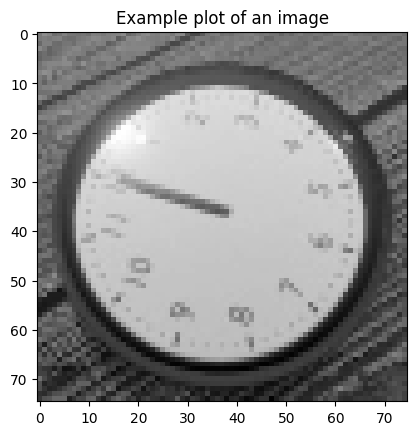

In [5]:
#Converted the image values to a range of [0, 1], better for network to work with
X, y = np.load('data_75/images.npy')/255.0, np.load('data_75/labels.npy')

plt.title('Example plot of an image')
plt.imshow(X[1], cmap='grey')


Text(0.5, 1.0, 'Inverted grayscale image')

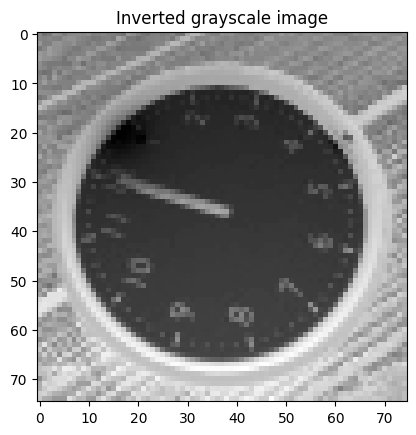

In [26]:
plt.imshow(1 - X[1], cmap='grey')
plt.title('Inverted grayscale image')

# Start training for regression

In [ ]:
# Split data into 80/10/10% train/validation/test split
data_train, data_temp = keras.utils.split_dataset((X, y), 0.8, shuffle=True, seed=2024)
data_valid, data_test = keras.utils.split_dataset(data_temp, 0.5, shuffle=True, seed=2024)

#Convert iterable back to images -> (samples, 75, 75), labels -> (sampels, 2)
X_train, y_train = next(iter(data_train.batch(len(data_train))))
X_valid, y_valid = next(iter(data_valid.batch(len(data_valid))))
X_test, y_test = next(iter(data_test.batch(len(data_test))))

print(X_train.shape)

(14400, 75, 75)
